<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/Wnet_IDRid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def atten(x,g,F_x,F_g,F_int,kernel_size=(3,3), padding="same", strides=1):
    # upsample lower decoder filters
    us = keras.layers.UpSampling2D((2, 2))(g)
    gate = keras.layers.Conv2D(F_g, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    gate=tf.keras.layers.BatchNormalization()(gate)
    
    # convolve the upsampled decoder filter for F_int filters
    W_g=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(gate)
    W_g=tf.keras.layers.BatchNormalization()(W_g)
    
    # convolve encoder output for F_int filters
    W_x=keras.layers.Conv2D(F_int, kernel_size=1, padding=padding, strides=strides)(x)
    W_x=tf.keras.layers.BatchNormalization()(W_x)
    
    # convolve to one attention filter
    psi=tf.keras.activations.relu(W_x+W_g, alpha=0.0, max_value=None, threshold=0)
    psi=keras.layers.Conv2D(1, kernel_size=1, padding=padding, strides=strides)(psi)
    psi=tf.keras.activations.sigmoid(tf.keras.layers.BatchNormalization()(psi))
    
    # return the filtered encoder output for concat
    return x*psi

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    #here x is the decoder output
    us = keras.layers.UpSampling2D((2, 2))(x)
    us = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(us)
    us = tf.keras.layers.BatchNormalization()(us)
    # here skip is from encoder and x if from dec previous layer 
    filtered_skip=atten(skip,x,filters,filters,filters/2)
    #concat filtrd skip and upsampled us
    concat = keras.layers.Concatenate( )([us, filtered_skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c=tf.keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c=tf.keras.layers.BatchNormalization()(c) 
    return c

In [4]:
def WNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48] 
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p10 = inputs
    c11, p11 = down_block(p10, f[0]) #128 -> 64
    c12, p12 = down_block(p11, f[1]) #64 -> 32
    c13, p13 = down_block(p12, f[2]) #32 -> 16
    c14, p14 = down_block(p13, f[3]) #16->8
    
    bn1 = bottleneck(p14, f[4])#8*8*48
    
    u11 = up_block(bn1, c14, f[3]) #8 - > 16
    u12 = up_block(u11, c13, f[2]) #16 -> 32
    u13 = up_block(u12, c12, f[1]) #32 -> 64
    u14 = up_block(u13, c11, f[0]) #64 -> 128
    
    output1 = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u14)
    
    p20=keras.layers.Concatenate( )([p10,output1*p10])
    c21, p21 = down_block(p20, f[0]) #128 -> 64
    c22, p22 = down_block(p21, f[1]) #64 -> 32
    c23, p23 = down_block(p22, f[2]) #32 -> 16
    c24, p24 = down_block(p23, f[3]) #16->8
    
    bn2 = bottleneck(p24, f[4])#8*8*48
    
    u21 = up_block(bn2, c24, f[3]) #8 - > 16
    u22 = up_block(u21, c23, f[2]) #16 -> 32
    u23 = up_block(u22, c22, f[1]) #32 -> 64
    u24 = up_block(u23, c21, f[0]) #64 -> 128
    output2 = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u24)
    outputs=[output1,output2]
    outputs=tf.stack(outputs,axis=4)
    #print(output1.shape,output2.shape)
    model = keras.models.Model(inputs, outputs)
    return model

In [5]:
from sklearn.utils import shuffle
from matplotlib.pyplot import imread
from cv2 import resize
import matplotlib.pyplot as plt
import cv2

In [6]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/a. Training Set"
train_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            train_data.append(os.path.join(dirName,fileName))

print(len(train_data))

54


In [7]:
# groundtruths for hard exudates
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/"
#data_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates"
train_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              #train_data_gt.append(os.path.join(dirName,filename))
  train_data_gt.append(seg_mask)
print(len(train_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates
4


In [8]:
def data_gen(x_path_list,y_path_list,batch_size=3):
  """
  Return batches of input image and segmentaion mask 
  """  
  train_batch = np.zeros(shape = (3, 512, 512, 3));
  
  train_label = np.zeros(shape = (3, 512, 512, 1));
  counter=0
  skipped=0
  while True :
    
    #image
    train_batch[0, :, :,:] = resize(imread(x_path_list[counter+skipped]), (512, 512))
    #label
    if x_path_list[counter+skipped][-6:-4]==y_path_list[counter][-9:-7]:
      img = cv2.cvtColor(imread(y_path_list[counter]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      train_label[0, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
      
      #flip
      train_batch[1, :, :,:]=np.flip(train_batch[0, :, :,:],axis=1)
      train_label[1, :, :,:]=np.flip(train_label[0, :, :,:],axis=1)
      #rotate
      train_batch[2, :, :,:]=np.rot90(np.rot90(train_batch[0, :, :,:]))
      train_label[2, :, :,:]=np.rot90(np.rot90(train_label[0, :, :,:]))
      train_batch/=255
      train_label[:,:,:,0]  = (train_label[:,:,:,0] - train_label[:,:,:,0].min(axis=0)) / (train_label[:,:,:,0].max(axis=0) - train_label[:,:,:,0].min(axis=0)+1e-10)
      mask = train_label[:,:,:,:] > 0.3
      train_label[mask] = 1.0
      train_label[~mask] = 0.0
      yield train_batch,train_label
      counter+=1
    else:
      skipped+=1
      
    
    if counter>=len(y_path_list):
      counter=0
      skipped=0

In [9]:
from keras import backend as K
def manual_loss(y_true, y_pred, smooth=1):
  cum_dice=0
  #print(y_pred.shape)
  for i in range(2):
    #print("input shape",y_true.shape,"output shape",y_pred[:,:,:,:,i].shape)
    intersection = K.sum(y_true * y_pred[:,:,:,:,i], axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred[:,:,:,:,i], axis=[1,2,3])
    cum_dice += K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  
  return 2-cum_dice

In [51]:
from keras import backend as K
def bce_loss(y_true, y_pred, smooth=1):
  #
  # binary cross entropy
  w1=tf.reduce_sum(y_true)
  w2=image_size*image_size
  weights=[w1/w2,1-w1/w2]
  bce1 = tf.keras.losses.BinaryCrossentropy()(y_true,y_pred[:,:,:,:,0])
  bce2 = tf.keras.losses.BinaryCrossentropy()(y_true,y_pred[:,:,:,:,1])

  return bce1+bce2

In [52]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size = 512

#set hyperparameters
epochs = 100
#batch_size = 2
model=WNet()

opt=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.8,decay=0.001/epochs) 
model.compile(optimizer=opt, loss=bce_loss)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=8)
#rlrop=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3)
gen=data_gen(train_data,train_data_gt[2])
hist=model.fit(gen,steps_per_epoch=len(train_data_gt[2]), epochs = 100, verbose = 1, callbacks=[early_stopping],shuffle='Batch')

Epoch 1/100
54/54 [==============================] - 18s 326ms/step - loss: 1.4575
Epoch 2/100
54/54 [==============================] - 18s 329ms/step - loss: 1.2149
Epoch 3/100
54/54 [==============================] - 18s 332ms/step - loss: 1.0529
Epoch 4/100
54/54 [==============================] - 18s 331ms/step - loss: 0.9129
Epoch 5/100
54/54 [==============================] - 18s 331ms/step - loss: 0.7806
Epoch 6/100
54/54 [==============================] - 18s 330ms/step - loss: 0.6595
Epoch 7/100
54/54 [==============================] - 18s 331ms/step - loss: 0.5533
Epoch 8/100
54/54 [==============================] - 18s 334ms/step - loss: 0.4638
Epoch 9/100
54/54 [==============================] - 18s 331ms/step - loss: 0.3903
Epoch 10/100
54/54 [==============================] - 18s 330ms/step - loss: 0.3311
Epoch 11/100
54/54 [==============================] - 18s 330ms/step - loss: 0.2837
Epoch 12/100
54/54 [==============================] - 18s 328ms/step - loss: 0.2465
E

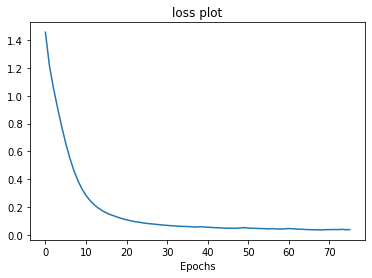

In [53]:
 plt.plot(hist.history['loss'])
plt.title("loss plot")
plt.xlabel("Epochs")
plt.show()

## Test data read

In [13]:
# data
data_location = "/content/drive/My Drive/IDRid/A. Segmentation/1. Original Images/b. Testing Set"
test_data = []  # create an empty list
for (dirName, subdirList, fileList) in sorted(os.walk(data_location)):
    for fileName in sorted(fileList):
        if ".jpg" in fileName.lower() :
            test_data.append(os.path.join(dirName,fileName))

In [14]:
target_root_location = "/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/"

test_data_gt = []  # create an empty list
segs=['1. Microaneurysms','2. Haemorrhages','3. Hard Exudates','4. Soft Exudates']
for seg in segs:
  data_location=target_root_location+seg
  print(data_location)
  seg_mask=[]
  for dirName, subdirList, fileList in sorted(os.walk(data_location)):
      for filename in sorted(fileList):
          if ".tif" in filename.lower() :
              seg_mask.append(os.path.join(dirName,filename))
              
  test_data_gt.append(seg_mask)
print(len(test_data_gt));

/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates
/content/drive/My Drive/IDRid/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates
4


In [ ]:
test_batch = np.zeros(shape = (len(test_data), 512, 512, 3));
test_labels_ls=[]


for file_index in range(0,len(test_data)):
    #print(file_index)
    # image
    test_batch[file_index, :, :,:] = resize(imread(test_data[int(file_index)]), (512, 512))

# Normalize
test_batch  = test_batch/255


# labels
for seg in test_data_gt:
    # here i am initializing it to 27 size though original mask no may be diff
    test_label = np.zeros(shape = (len(test_data), 512, 512, 1));
    # but i am filing the test_label serially ie if one mask is not there i am not leaving that place balnk but filing the next mask in its place
    for file_index in range(0,len(seg)):  
      img = cv2.cvtColor(imread(seg[file_index]), cv2.COLOR_BGRA2BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      test_label[file_index, :, :,:] = np.expand_dims(resize(img, (512, 512)), axis = 2)
    # scale to 0-1
    test_label[:,:,:,0]  = (test_label[:,:,:,0] - test_label[:,:,:,0].min(axis=0)) / (test_label[:,:,:,0].max(axis=0) - test_label[:,:,:,0].min(axis=0)+1e-10)
    # binarize the masks
    mask = test_label[:,:,:,:] > 0.3
    test_label[mask] = 1.0
    test_label[~mask] = 0.0
    # append masks to common list
    test_labels_ls.append(test_label)


print(test_batch.shape)
print(test_labels_ls[0].shape)

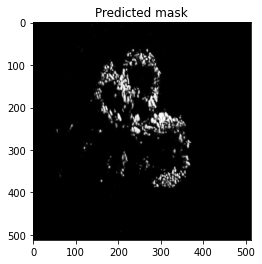

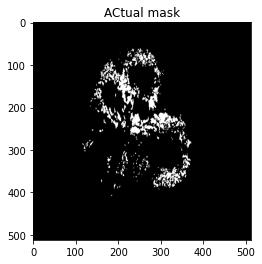

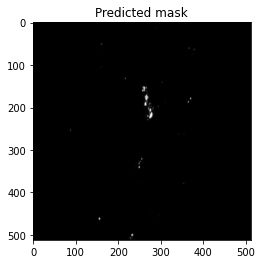

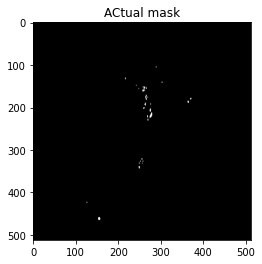

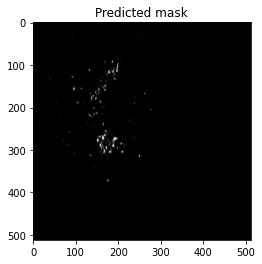

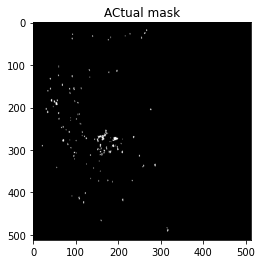

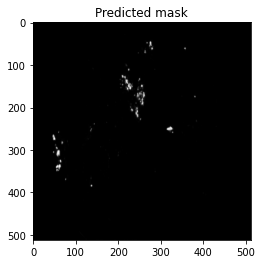

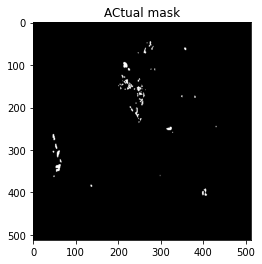

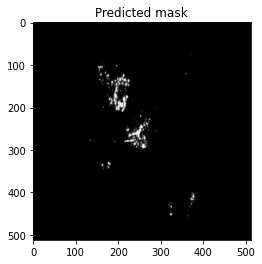

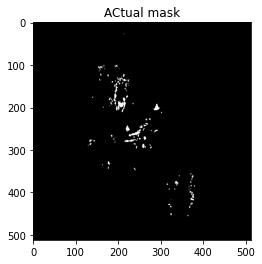

In [54]:
predicted_test_label=model.predict(test_batch)[:,:,:,:,1]
for i in range(5): 
  plt.imshow(np.squeeze(predicted_test_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("Predicted mask")
  plt.show()
  plt.imshow(np.squeeze(test_labels_ls[2][i,:,:,:],axis=2),cmap='gray')
  plt.title("ACtual mask")
  plt.show()

In [55]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(np.round(test_labels_ls[2].reshape(-1)),predicted_test_label.reshape(-1))
print("Auc-Roc score :", auc)
print("---------------------")

Auc-Roc score : 0.9796202510258581
---------------------


In [56]:
from sklearn.metrics import f1_score
testy, yhat_classes=(test_labels_ls[2].reshape(-1),np.round(predicted_test_label.reshape(-1)))
test_f1 = f1_score(testy, yhat_classes)
#testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
#train_f1 = f1_score(testy, yhat_classes)
train_f1=np.nan
print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

Train  F1 score: nan Test F1 score: 0.657338


 test AUPR 0.748967870862579


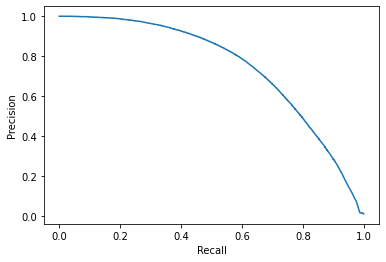

In [57]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

test_aupr = precision_recall_curve(test_labels_ls[2].reshape(-1),predicted_test_label.reshape(-1))
test_auc=auc(test_aupr[1],test_aupr[0])
print(" test AUPR",test_auc)
plt.plot(test_aupr[1],test_aupr[0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [72]:
model_json = model.to_json()
with open("model_{}.json".format(segs[2]), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_{}.h5".format(segs[2]))
print("Saved model to disk")

Saved model to disk


In [58]:
def UNet():
    #f = [16, 32, 64, 128, 256]
    f = [3, 6, 12, 24, 48]
    
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])#8*8*48
    
    u1 = up_block(bn, c4, f[3]) #8 - > 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [65]:
seed = 2
random.seed = seed
np.random.seed = seed
tf.seed = seed
tf.random.set_seed(2)
image_size = 512

#set hyperparameters
epochs = 100

model_u=UNet()
opt=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,decay=0.001/epochs)
model_u.compile(optimizer=opt, loss="bce")
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta	=0.001, patience=8)
#rlrop=tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3)
gen=data_gen(train_data,train_data_gt[2])
hist=model_u.fit(gen,steps_per_epoch=len(train_data_gt[2]), epochs = 100, verbose = 1, callbacks=[early_stopping],shuffle='Batch')

Epoch 1/100
54/54 [==============================] - 16s 291ms/step - loss: 0.7147
Epoch 2/100
54/54 [==============================] - 16s 294ms/step - loss: 0.5895
Epoch 3/100
54/54 [==============================] - 16s 294ms/step - loss: 0.5111
Epoch 4/100
54/54 [==============================] - 16s 295ms/step - loss: 0.4385
Epoch 5/100
54/54 [==============================] - 16s 295ms/step - loss: 0.3698
Epoch 6/100
54/54 [==============================] - 16s 295ms/step - loss: 0.3085
Epoch 7/100
54/54 [==============================] - 16s 295ms/step - loss: 0.2557
Epoch 8/100
54/54 [==============================] - 16s 295ms/step - loss: 0.2115
Epoch 9/100
54/54 [==============================] - 16s 295ms/step - loss: 0.1760
Epoch 10/100
54/54 [==============================] - 16s 293ms/step - loss: 0.1475
Epoch 11/100
54/54 [==============================] - 16s 295ms/step - loss: 0.1251
Epoch 12/100
54/54 [==============================] - 16s 293ms/step - loss: 0.1071
E

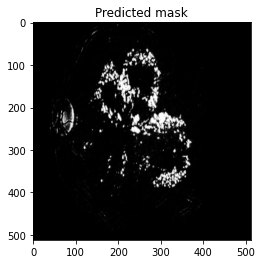

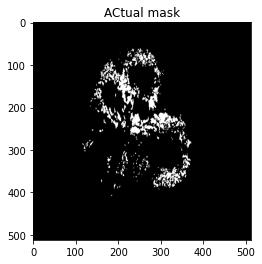

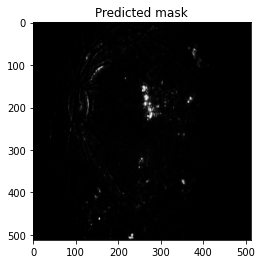

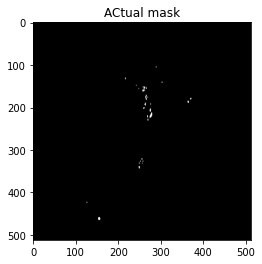

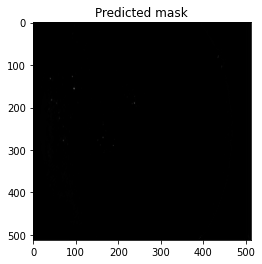

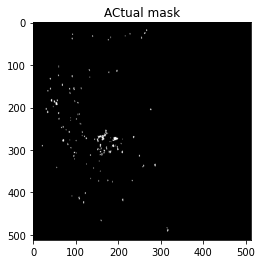

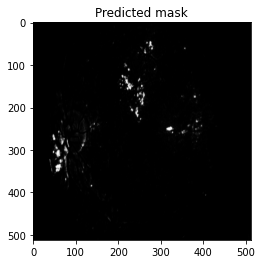

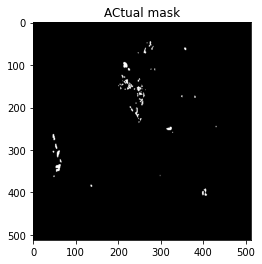

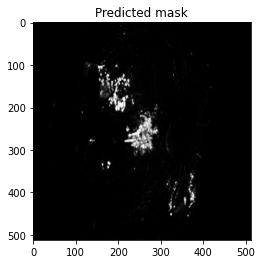

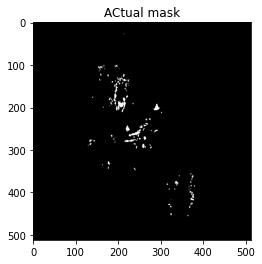

In [66]:
predicted_test_label=model_u.predict(test_batch)
for i in range(5): 
  plt.imshow(np.squeeze(predicted_test_label[i,:,:,:],axis=2),cmap='gray')
  plt.title("Predicted mask")
  plt.show()
  plt.imshow(np.squeeze(test_labels_ls[2][i,:,:,:],axis=2),cmap='gray')
  plt.title("ACtual mask")
  plt.show()

In [67]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(np.round(test_labels_ls[2].reshape(-1)),predicted_test_label.reshape(-1))
print("Auc-Roc score :", auc)
print("---------------------")

Auc-Roc score : 0.8262342087264329
---------------------


In [68]:
from sklearn.metrics import f1_score
testy, yhat_classes=(test_labels_ls[2].reshape(-1),np.round(predicted_test_label.reshape(-1)))
test_f1 = f1_score(testy, yhat_classes)
#testy, yhat_classes=train_label.reshape(-1),np.round(predicted_train_label.reshape(-1))
#train_f1 = f1_score(testy, yhat_classes)
train_f1=np.nan
print('Train  F1 score: %f' % train_f1,'Test F1 score: %f' % test_f1)

Train  F1 score: nan Test F1 score: 0.554403


 test AUPR 0.5299755750982786


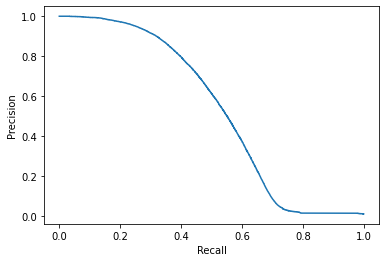

In [70]:
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

test_aupr = precision_recall_curve(test_labels_ls[2].reshape(-1),predicted_test_label.reshape(-1))
test_auc=auc(test_aupr[1],test_aupr[0] )
print(" test AUPR",test_auc)
plt.plot(test_aupr[1],test_aupr[0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()